# 8 Dimensionality Reduction

## The curse of Dimensionality

Here's a fun fact: if you pick two points randomly in a unit square, the distance between these two points will be, on average, roughly 0.52. If you pick two random points in a unit 3D cube, the average distance will be 0.66. If you picked two points in a 1,000,000 dimensional hypercube, that distance would be about 408.25!

This example shows that high-dimension datasets can be very sparse; most training instances will likely be far away from each other. 

This also means that any new instance will be far away from any training instance, making predictions much less reliable than in lower dimensions. In short, the more dimensions the training set has, the more likely it is to overfit.

## Main approaches for dimensionality reduction

### Projection

In most real-world problems, training instances are *not* spread out uniformlyy across all dimensions. Many features are almost constant, while others are highly correlated. As a result, many instances lie within a much lower-dimensional subspace of the high-dimensional space.

Book shows example of 3D dataset that can be efficiently projected on 2D plane.

Counter example pg 217: Swiss roll dataset, projecting onto a plane would squash different layers of the swiss roll together.

### Manifold Learning

A *d*-dimensional manifold is part of an *n*-dimensional space (*d<N*) that locally resembles a *d*-dimensional hyperplane. In the case of the swiss roll, d=2 and n=3; it locally resembles a 2D plane but it is rolled in the thirds dimension

Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie; this is called **manifold learning**. It relies on the *manifold assumption* (or manifold hypothesis) which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold. This assumption is very often empirically observed.

The manifold assumption is often accompanies by another implicit assumption: that the task at hand (e.g. classification or regression) will be simpler if expressed in the lower-dimensional space of the manifold. Figure 8-6 on page 219 exemplifies this.

In short, reducing the dimensionality of your training set before training a model will usually speed up training, but it may not alwasy lead to a better or simpler solution; it all depends on the dataset.

## PCA

*Principal component analysis* is by far the most popular dimensionality reduction algorithm used. First it identifies the hyperplane lying closest to the data, then projects the data onto it.

#### Preserving the variance

But how to choose the correct hyperplane? Choosing the axis that preserves the maximum amount minimises the amount of loss while projecting. (example fig 8-7 pg 220)

#### Principal components

PCA finds the acis that preserves the largest amount of variance in the training set. It also finds the a second axis (orthogonal to the first) that accounts for the largest amount of remaining variance. 

For each principal component, PCA finds a zero-centered unit vector pointing in the direction of the PC. Since two opposing unit vectors lie on th same axis, the direction of the unit vectors returned by PCA is not stable; if the training set is perturbed slightly and PCA ran again, the unit vectors may point in the opposite direction. However they will generally lie on the same axes.

How to find the principal components of a training set? Use a matrix factorization technique called *Singular Value Decomposition* (**SVD**), that can decompose the training set matrix $\textbf{X}$ into the matrix multiplication of three matrices $\textbf{U}\Sigma\textbf{V}^{\intercal}$, where $\textbf{V}$ contains the unit vectors that define all the principal components

In [15]:
import sys
import sklearn
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('seaborn')

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

3D dataset used

In [3]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [10]:
X[:5,:]

array([[-1.01570027, -0.55091331, -0.26132626],
       [-0.00771675,  0.59958572,  0.03507755],
       [-0.95317135, -0.46453691, -0.24920288],
       [-0.92012304,  0.21009593,  0.02182381],
       [-0.76309739,  0.158261  ,  0.19152496]])

We can use numpy's *svd()* function to obtain principal components

In [5]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [11]:
c1

array([0.93636116, 0.29854881, 0.18465208])

Note: PCA assumes that the dataset is centered around the origin. Sklearn's PCA classes takes care of centering the data for you, but if you implement it yourself, don't forget to center the data

#### Projecting down to *d* dimensions
Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to *d* dimensions by projecting it onto the hyperplane defined by the first *d* principal components. Selecting this hyperplane ensures that the projection will preserve as much variance as possible.

To project the training set onto the hyperplane and obtain a reduced dataset $X_{d-proj}$ of dimensionality d, compute the matrix multiplication of the training set matrix $X$ by the matrix $W_d$, defined as the matrix containing the first $d$ columns of $V$, as follows

$$ X_{d-proj} = XW_d $$

The following code projects the training set onto the plane defined by the first two principal components

In [13]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D[:5, :]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [17]:
X2D_using_svd = X2D

Below is the original 3D dataset

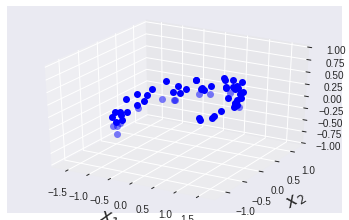

In [31]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

X3D_above = X[X[:, 2] > X3D_inv_using_svd[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv_using_svd[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

And when projected onto a 2D hyperplane, note that the black arrows indicate the principal components

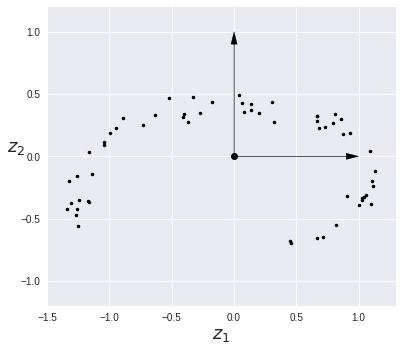

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
plt.show()

### Using Scikit-Learn
Scikit-learn also uses SVD to implement PCA. The attribute components_ holds the transpose of $W_d$

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [39]:
pca.components_.T

array([[-0.93636116,  0.34027485],
       [-0.29854881, -0.90119108],
       [-0.18465208, -0.2684542 ]])